In [100]:
import gymnasium as gym
import math
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "CPU"
)

env = gym.make('CartPole-v1')
#env.env.env.env.length = 0.1
state = env.reset()

In [101]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [102]:
class SurrogateModel(nn.Module):

    def __init__(self, inputs, outputs):
        super(SurrogateModel, self).__init__()
        self.layer1 = nn.Linear(inputs, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [103]:
# Set up the agent that will explore the env
class DQN_Agent :
    def __init__(self, model_file='DQN_agent.pth'):
        self.agent = torch.load(model_file, weights_only=False,map_location=device)
    def get_action(self,obs):
        #t = torch.tensor([obs])
        #print("t.is_cuda",t.is_cuda)
        return self.agent(obs.cuda()).max(1).indices.view(1, 1)
agent = DQN_Agent()


In [104]:
# Get number of actions from gym action space
n_actions = env.action_space.n
print("n_actions:",n_actions)
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print("n_observations:",n_observations)

# Initialize surrogate
surrogate = SurrogateModel(n_observations+1,n_observations).to(device)

# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(surrogate.parameters(), lr=0.001, amsgrad=True)

steps_done = 0


n_actions: 2
n_observations: 4


In [105]:
def train_surrogate(N_EPISODES=100,MAX_STEPS=200,OPTIMIZE=True):
    losses = []
    errors = []
    rewards = []
    measurement_means = []
    measurement_rmss = []
    debug_print = False
    
    for i in range(N_EPISODES):
        obs,info = env.reset()
        obs = torch.Tensor(obs.reshape((1,4)))
        term = False
        outputs = torch.empty(size=(1,4))
        inputs = torch.empty(size=(1,5))
        targets = torch.empty(size=(1,4))
        #print("outputs",outputs )
        #print("inputs",inputs)
        #print("targets",targets)
    
        step_num = 0 
        while not term :
            if step_num>MAX_STEPS : break
            # perform step
            previous_obs = obs
            action = agent.get_action(obs)
            obs,reward,term,trunc,info = env.step(action[0][0].item())
            obs = torch.Tensor(obs.reshape((1,4)))
            if debug_print :
                print("============================")
                print("step:",step_num)
                print("previous_obs:",previous_obs)
                print("obs:",obs)
                print("reward:",reward)
                print("term:",term)
                print("angle:",obs[0][2].item())
                print("action:",action)
            if not term :
                if step_num == 0 :
                    inputs = torch.cat( (previous_obs.cuda(),action), dim=1 )
                    targets = obs.cuda()
                else :
                    # save step information 
                    temp = torch.cat( (previous_obs.cuda(),action), dim=1 )
                    inputs  = torch.cat(( inputs.cuda(), temp ))
                    targets = torch.cat(( targets.cuda(), obs.cuda() )) 
                if debug_print :
                    print("input:",previous_obs)
                    print("target:",obs)
            step_num = step_num+1
            
        outputs = surrogate(inputs) 
        if debug_print : 
            print("%%%%%%%%%%")
            print("inputs:",inputs)
            print("outputs:",outputs)
            print("targets:",targets)
            print("%%%%%%%%%%")    
        loss = criterion(outputs.cuda(), targets.cuda())

        if OPTIMIZE :
            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            #torch.nn.utils.clip_grad_value_(surrogate.parameters(), 100)
            optimizer.step()
            if debug_print : print(loss.item())
            losses.append(loss.item())

        errors.append(torch.norm(targets-outputs).mean().item())
        measurement_mean = targets.mean(dim=0)
        measurement_means.append(measurement_mean.tolist())
        measurement_rms = targets.std(dim=0)
        measurement_rmss.append(measurement_rms.tolist())
        rewards.append(step_num)
    return {"losses":losses,
            "errors":errors,
            "rewards":rewards,
            "measurement_means":measurement_means,
            "measurement_rmss":measurement_rmss}
    


In [106]:
def plot_results(results_):
    figure, axis = plt.subplots(1, 5)

    figure.set_figwidth(18)
    
    axi = axis[0]
    axi.plot(results_["losses"])
    axi.set_title("Losses Versus Episode")
    axi.set_yscale('log')
    
    axi = axis[1]
    means = torch.Tensor(results_['measurement_means'])
    #print(means)
    axi.plot(torch.transpose(means,0,1)[2])
    #axi.plot(torch.transpose(means,0,1)[3])
    #axi.plot(torch.transpose(means,0,1)[0])
    #axi.plot(torch.transpose(means,0,1)[1])
    axi.set_title("Mean angle Versus Episode")
    
    axi = axis[2]
    rms = torch.Tensor(results_['measurement_rmss'])
    #print(rms)
    axi.plot(torch.transpose(rms,0,1)[2])
    #axi.plot(torch.transpose(rms,0,1)[3])
    #axi.plot(torch.transpose(rms,0,1)[0])
    #axi.plot(torch.transpose(rms,0,1)[1])
    axi.set_title("RMS of angle Versus Episode")
    
    axi = axis[3]
    axi.plot(results_['rewards'])
    axi.set_title("Reward per Episode")

    axi = axis[4]
    axi.plot(results_['errors'])
    axi.set_title("Avg. Error per Episode")
    
    plt.show()

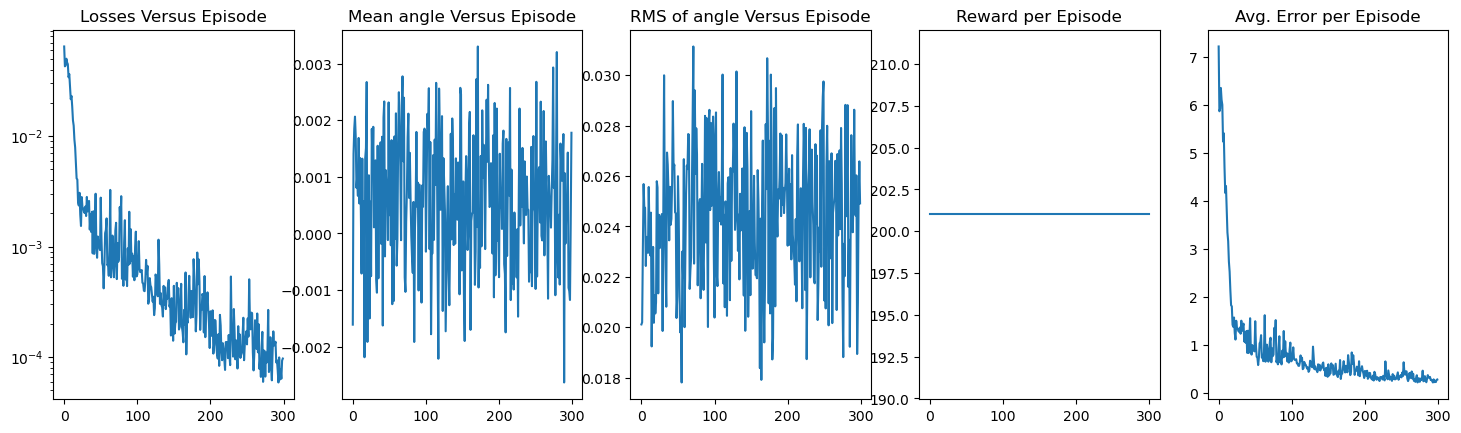

In [107]:
results = train_surrogate(300)
plot_results(results)

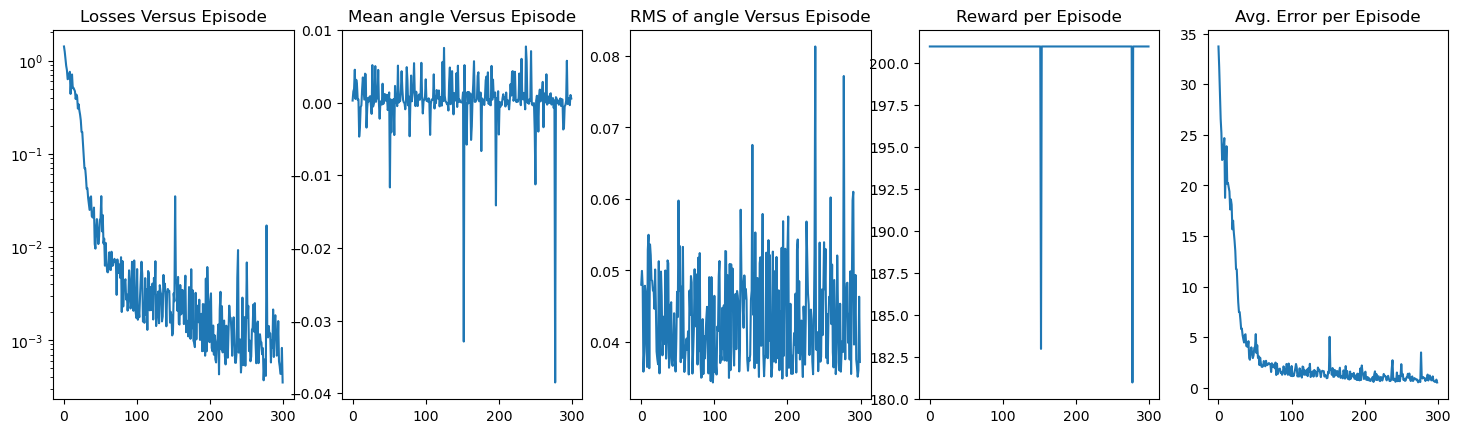

In [108]:
env.env.env.env.length = 0.05
results = train_surrogate(300)
plot_results(results)

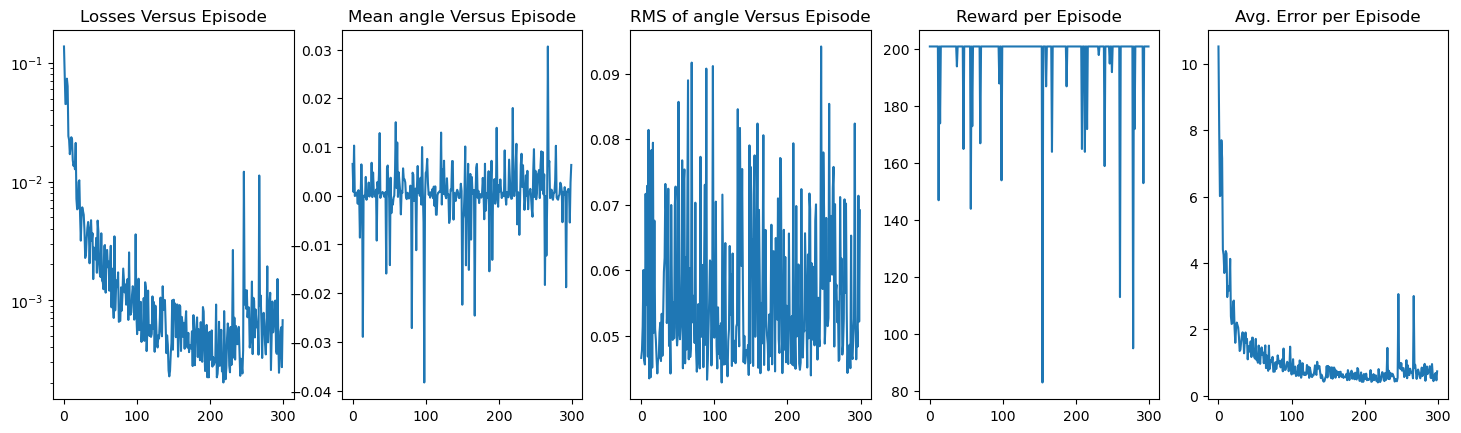

In [109]:
env.env.env.env.length = 0.04
results = train_surrogate(300)
plot_results(results)

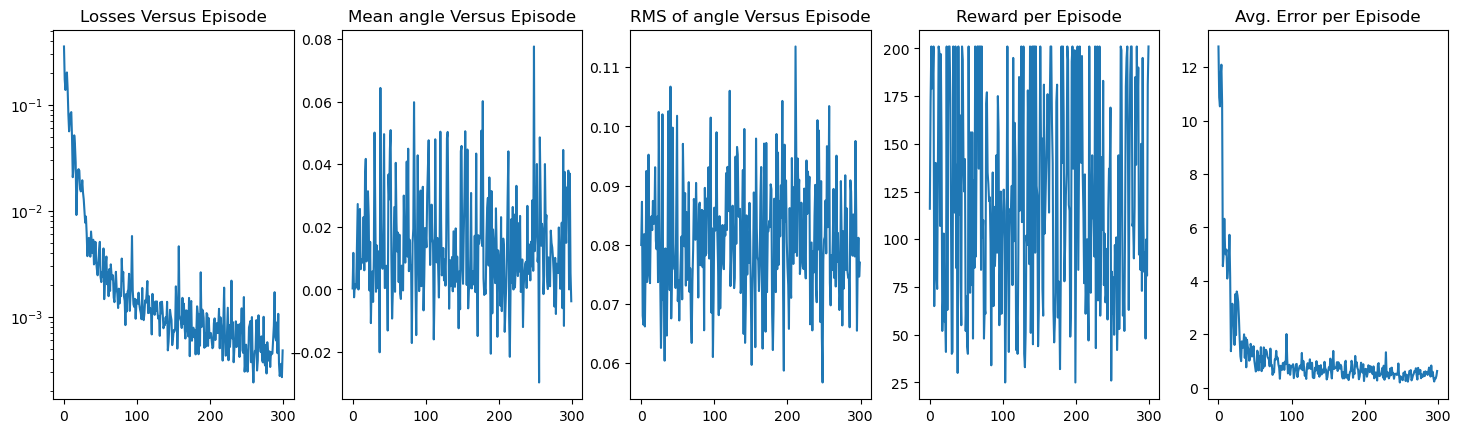

In [110]:
env.env.env.env.length = 0.03
results = train_surrogate(300)
plot_results(results)

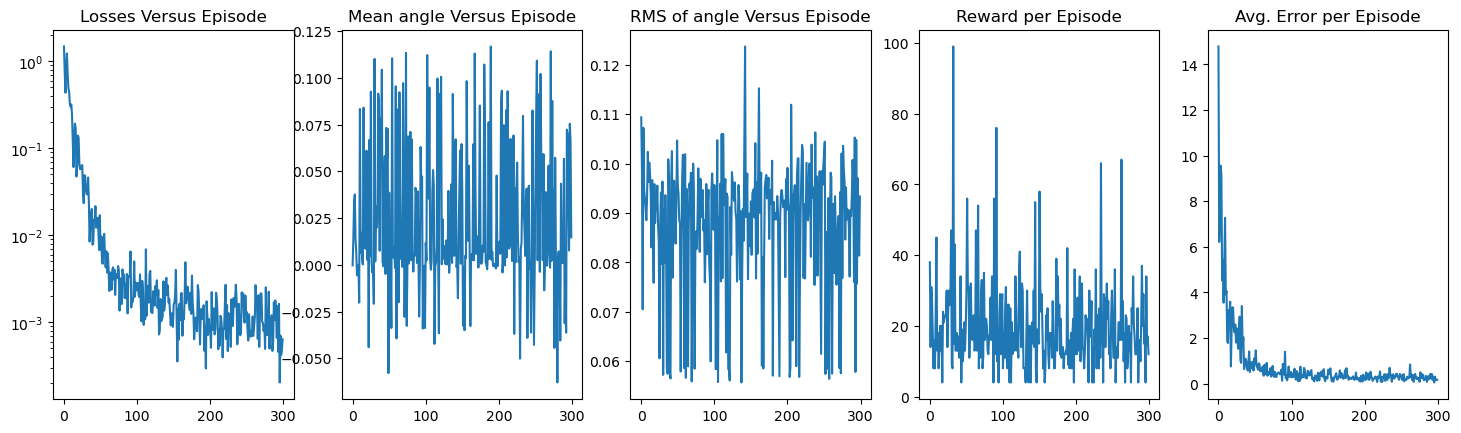

In [111]:
env.env.env.env.length = 0.02
results = train_surrogate(300)
plot_results(results)

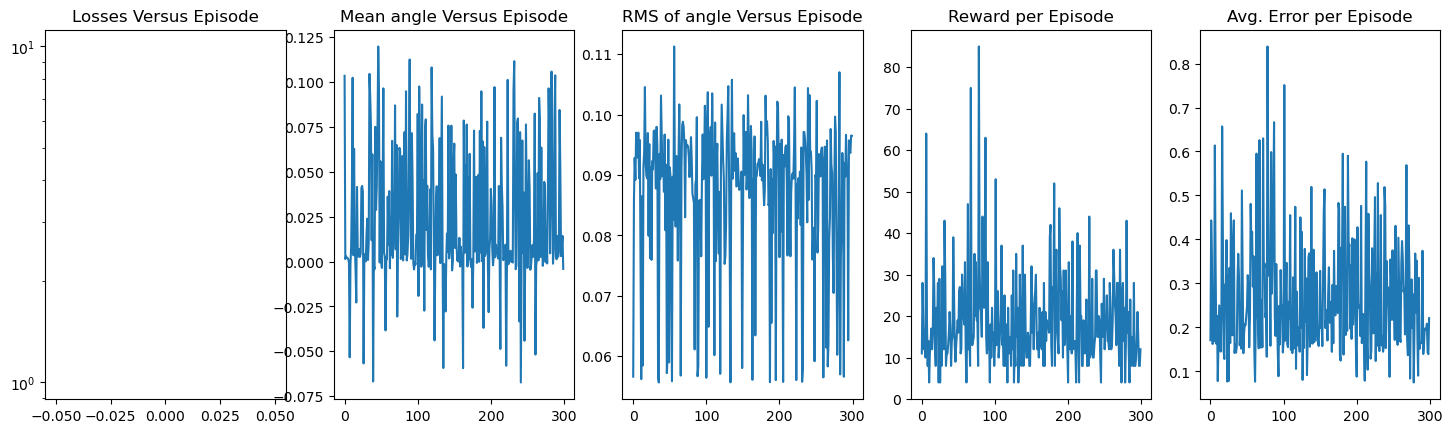

In [112]:
results = train_surrogate(300,200,False)
plot_results(results)

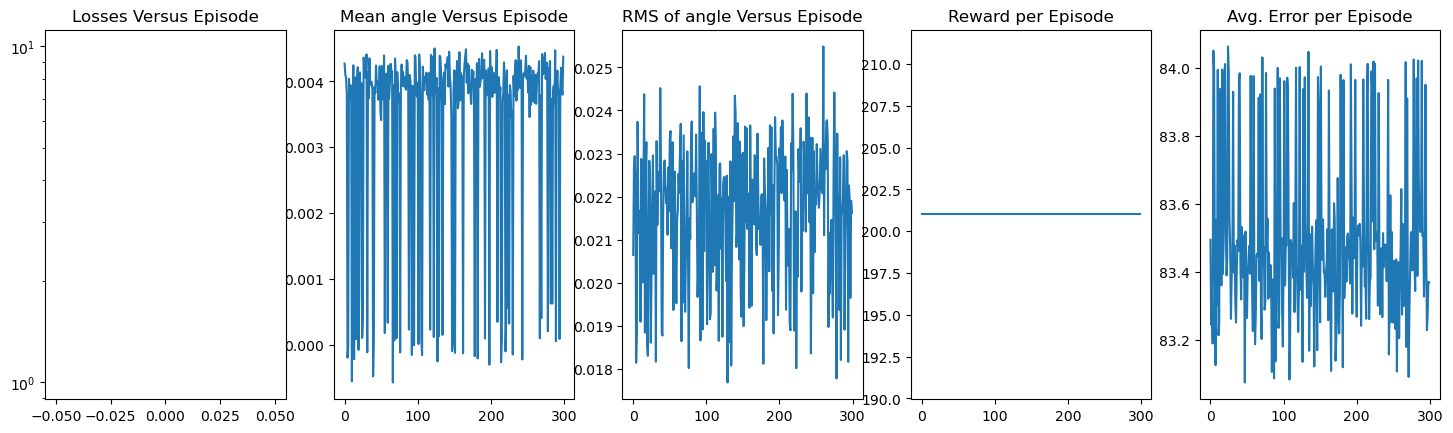

In [113]:
env.env.env.env.length = 0.1
results = train_surrogate(300,200,False)
plot_results(results)